In [2]:
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
# import ruamel.yaml
import yaml
import re
import ast

import math
import sys
import traceback
from csv import excel
from collections import Counter
from scipy import stats

# test_name = "1p9f9s_run"
test_name = "seq6f3s"

stat_path=f"../example_stat/{test_name}"
iamge_path=f"{stat_path}/images"



In [3]:

import os
import re

def search_files_with_name(directory, pattern):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if re.search(pattern, file) and 'png' not in file:
                file_list.append(os.path.join(root, file))
                #print(os.path.join(root, file))
    return file_list


    

    
# Read in task_to_file mapping yaml file
def load_task_file_map(test_name):
    task_file_map = {}
    with open(f"{stat_path}/{test_name}-task_to_file.yaml", "r") as stream:
        try:
            task_file_map = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return task_file_map

task_file_map = load_task_file_map(test_name)

def add_task_nodes(G, tfe_dic):
    skip_pos = 2
    task_pos = 2
    # task_file_edges dictionay
    for task_name,v in tfe_dic.items():
        task_order = v['order']
        node_attrs = {task_name: {'order': task_order, 'type':'task', 'stat':v}}
        G.add_node(task_name, pos=(task_pos,0))
        nx.set_node_attributes(G, node_attrs)
        task_pos += skip_pos


In [4]:
def get_file_nodes_names_in_order(G):
    file_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'file']
    data = []
    for n in file_nodes:
        order = G.nodes[n]['order']
        file_name = G.nodes[n]['stat']['file_name']
        data.append((order, file_name, n))
    return sorted(data, key=lambda x: x[0]) #everse=True

def remove_duplicate_file_nodes(G, keep_nodes):
    file_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'file']
    for n in file_nodes:
        if n not in keep_nodes:
            G.remove_node(n)


def add_task_file_edges(G, map_dic):
    file_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'file']
    file_node_rsorted = get_file_nodes_names_in_order(G)
    actual_file_nodes = []
    edge_list = []
    for task_name, v in map_dic.items():
        for file_name in v['input']:
            for i, triplet in enumerate(file_node_rsorted):
                if file_name == triplet[1]:
                    edge_list.append((triplet[2], task_name))
                    actual_file_nodes.append(triplet[2])
                    # file_node_rsorted.pop(i)
                    # update file node position
                    G.nodes[triplet[2]]['pos'] = (G.nodes[task_name]['pos'][0] - 1, G.nodes[triplet[2]]['pos'][1])
                    break

        for file_name in v['output']:
            for i, triplet in enumerate(file_node_rsorted):
                if file_name == triplet[1]:
                    edge_list.append((task_name, triplet[2]))
                    actual_file_nodes.append(triplet[2])
                    # file_node_rsorted.pop(i)
                    # update file node position
                    G.nodes[triplet[2]]['pos'] = (G.nodes[task_name]['pos'][0] + 1, G.nodes[triplet[2]]['pos'][1])
                    break

    for e in edge_list:
        print(f"added edge : {e[0]} -> {e[1]}")
    remove_duplicate_file_nodes(G, actual_file_nodes)
    G.add_edges_from(edge_list)
    return G

In [5]:
vol_files = search_files_with_name(stat_path, "vol")
# vol_files = vol_files[0:1]
print(vol_files)


def load_vol_yaml(vol_files):
    ret_dict = {}
    tmp_dict = {}
    for f in vol_files:
        with open(f, "r") as stream:
            print(f"loading {f}")
            try:
                tmp_dict = yaml.safe_load(stream)
                # print(tmp_dict)
            except yaml.YAMLError as exc:
                print(exc)
            ret_dict[f] = tmp_dict
    return ret_dict

vol_dict = load_vol_yaml(vol_files)
# print(vol_dict)

print("loading yaml done")


['../example_stat/seq6f3s/32510_vol-data-stat-dl.yaml']
loading ../example_stat/seq6f3s/32510_vol-data-stat-dl.yaml
loading yaml done


In [6]:


def display_all_nodes_attr(G):
    for node in G.nodes():
        print(f"Node Name: {node}")
        # print(f"- Statistics: {G.nodes[node]}")
        print(f"- Order: {G.nodes[node]['order']} - Type: {G.nodes[node]['type']} - Position: {G.nodes[node]['pos']}")
        print(f"- Statistics: {G.nodes[node]['stat']}")

def add_file_nodes(G, stat_dict):
    for stat_file, stat_list in stat_dict.items():
        # print(stat_file)
        for li in stat_dict[stat_file]:
            k = list(li.keys())[0]
            if 'file' in k:
                parts = k.split("-")
                # node_name = f"{k} : {li[k]['file_name']}"
                node_name = f"{li[k]['file_name']}"
                node_order = int(parts[1])
                node_attrs = {node_name: {'order': node_order, 'type':'file', 'stat':li[k]}}
                if not G.has_node(node_name):
                    G.add_node(node_name, pos=(0,node_order))
                    nx.set_node_attributes(G, node_attrs)

def add_dset_file_nodes_edges(G, stat_dict):
    node_order_list = {} # keeptrack of dataset order in each file
    for stat_file, stat_list in stat_dict.items():
        # print(stat_file)
        for li in stat_dict[stat_file]:
            k = list(li.keys())[0]
            if 'file' in k:
                parts = k.split("-")
                # node_name = f"{k} : {li[k]['file_name']}"
                file_node_name = f"{li[k]['file_name']}"
                task_name = f"{li[k]['task_name']}"
                node_order = int(parts[1])
                if node_order not in node_order_list:
                    node_order_list[node_order] = 0
                # TODO: add dataset node and file node and edges
                if 'datasets' in li[k]:
                    dset_node_stat = li[k]['datasets']
                    dset_node_name = f"{dset_node_stat['dset_name']}-{node_order}"
                    if '/' in dset_node_name: dset_node_name = dset_node_name.replace('/', '')
                    
                    access_type = dset_node_stat['access_type']
                    dset_node_attrs = {dset_node_name: {'order': node_order, 'type':'dataset', 'access_cnt':0, 'stat':li[k]['datasets']}}
                    # print(dset_node_attrs)
                    if access_type == 'read_only':
                        if not G.has_node(file_node_name):
                            G.add_node(file_node_name, pos=(0,node_order))
                        if not G.has_node(dset_node_name):
                            G.add_node(dset_node_name, pos=(1,node_order_list[node_order]))
                            node_order_list[node_order] += 1
                            nx.set_node_attributes(G, dset_node_attrs)
                        else:
                            G.nodes[dset_node_name]['access_cnt'] += 1
                        G.add_edge(file_node_name, dset_node_name, label=task_name)
                        
                    if access_type == 'write_only':
                        if not G.has_node(file_node_name):
                            G.add_node(file_node_name, pos=(1,node_order))
                        if not G.has_node(dset_node_name):
                            G.add_node(dset_node_name, pos=(0,node_order_list[node_order]))
                            node_order_list[node_order] += 1
                            nx.set_node_attributes(G, dset_node_attrs)
                        else:
                            G.nodes[dset_node_name]['access_cnt'] += 1
                        G.add_edge(dset_node_name, file_node_name, label=task_name)

                else:
                    # print(f"no datasets stat: {li[k]}")
                    node_attrs = {file_node_name: {'order': node_order, 'type':'file', 'stat':li[k]}}
                    if not G.has_node(file_node_name):
                        G.add_node(file_node_name, pos=(0,node_order))
                    nx.set_node_attributes(G, node_attrs) # maybe resetting stats

G_VOL = nx.DiGraph()

add_dset_file_nodes_edges(G_VOL, vol_dict)


display_all_nodes_attr(G_VOL)


Node Name: wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc
- Order: 2 - Type: file - Position: (0, 2)
- Statistics: {'file_name': 'wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'open_time': 1690947030274946, 'close_time': 1690947045100577, 'file_size': 17684963, 'header_size': 2048, 'sieve_buf_size': 65536, 'file_intent': ['H5F_ACC_RDONLY'], 'ds_created': 0, 'ds_accessed': 566, 'grp_created': 0, 'grp_accessed': 3, 'dtypes_created': 0, 'dtypes_accessed': 0}
Node Name: lat-2
- Order: 2 - Type: dataset - Position: (1, 0)
- Statistics: {'dset_name': 'lat', 'start_time': 1690947030277377, 'end_time': 1690947030279088, 'dt_class': 'H5T_FLOAT', 'ds_class': 'H5S_SCALAR', 'layout': 'H5D_CONTIGUOUS', 'storage_size': 4000, 'dset_n_elements': 1000, 'dimension_cnt': 1, 'dimensions': [1000], 'dset_type_size': 4, 'dataset_read_cnt': 1, 'total_bytes_read': 4000, 'dataset_write_cnt': 0, 'total_bytes_written': 0, 'access_type': 'read_only', 'dset_offset': -1, 'dset_select_type': 'H5S_SEL_ALL', 'dset

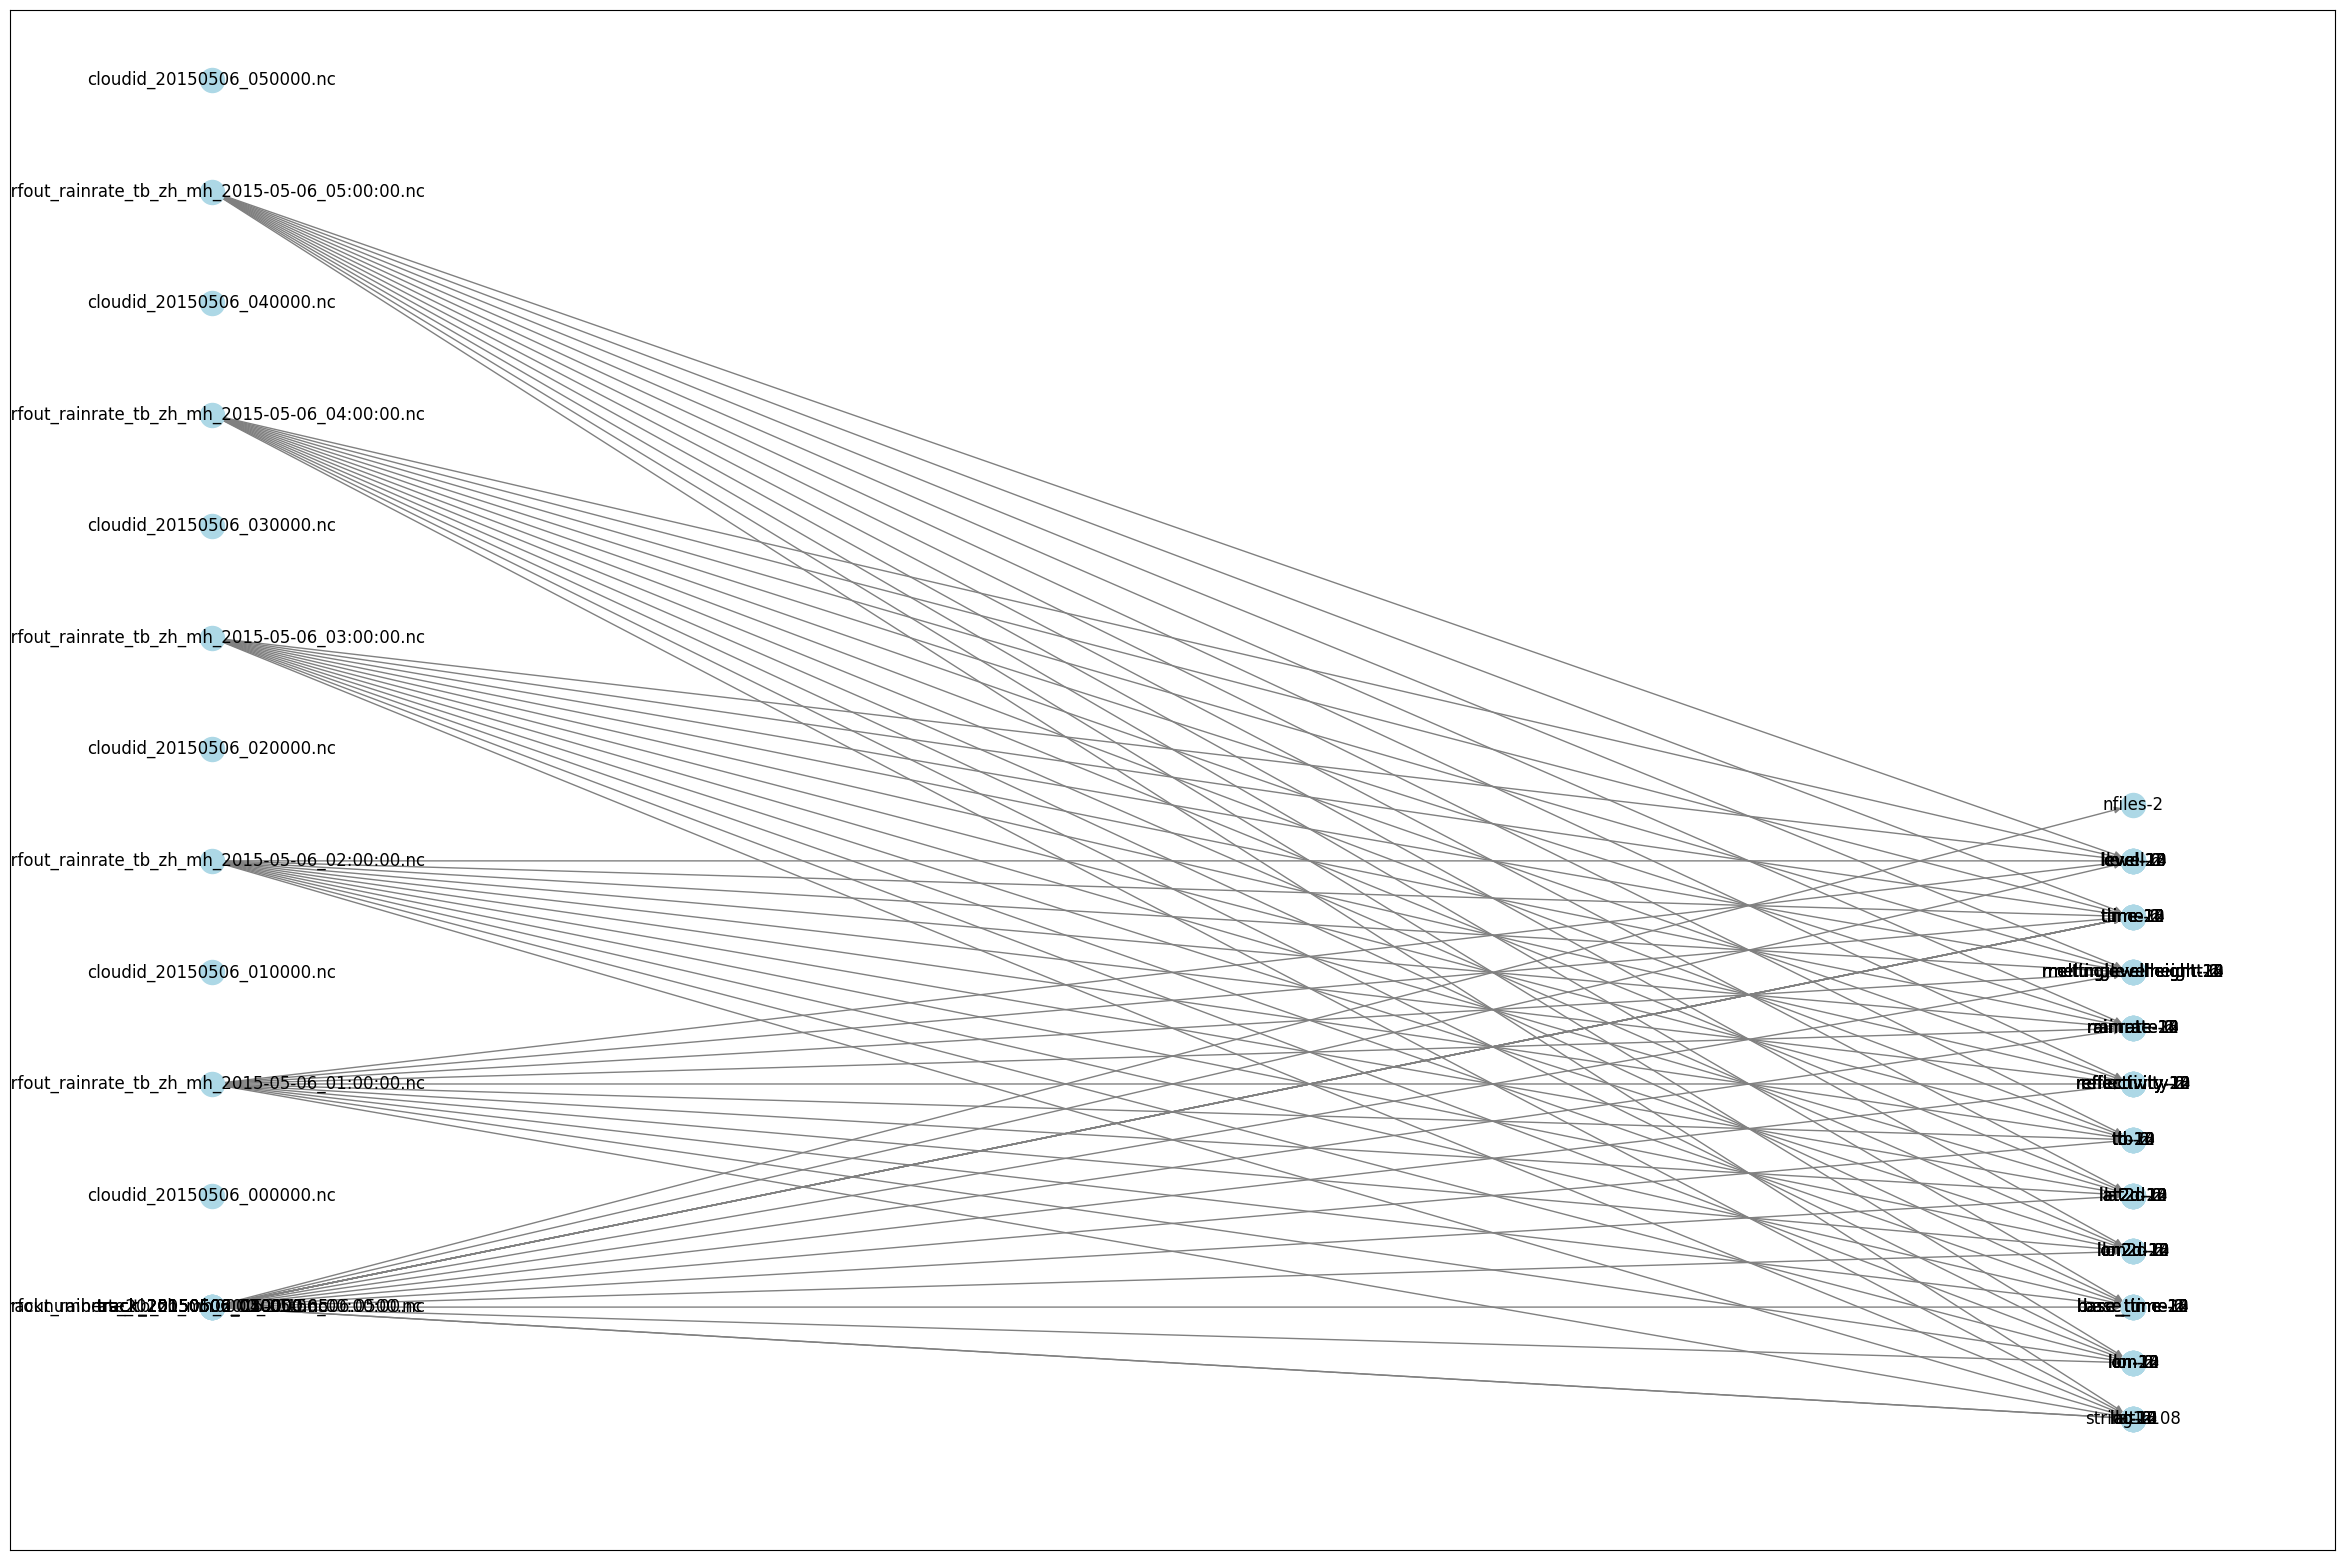

In [7]:
def draw_graph(G, test_name, save=False):
    plt.figure(figsize=(30, 20))
    pos = {node: data['pos'] for node, data in G.nodes(data=True)}
    # Draw the graph with node labels
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray')

    if save:
        save_image_path=f"../example_stat/{test_name}/{test_name}-vol-networkx.png"
        plt.savefig(save_image_path)
    
    # Show the graph
    plt.show()

draw_graph(G_VOL, test_name)

added edge : wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc -> run_idfeature
added edge : wrfout_rainrate_tb_zh_mh_2015-05-06_01:00:00.nc -> run_idfeature
added edge : wrfout_rainrate_tb_zh_mh_2015-05-06_02:00:00.nc -> run_idfeature
added edge : wrfout_rainrate_tb_zh_mh_2015-05-06_03:00:00.nc -> run_idfeature
added edge : wrfout_rainrate_tb_zh_mh_2015-05-06_04:00:00.nc -> run_idfeature
added edge : wrfout_rainrate_tb_zh_mh_2015-05-06_05:00:00.nc -> run_idfeature
added edge : run_idfeature -> cloudid_20150506_000000.nc
added edge : run_idfeature -> cloudid_20150506_010000.nc
added edge : run_idfeature -> cloudid_20150506_020000.nc
added edge : run_idfeature -> cloudid_20150506_030000.nc
added edge : run_idfeature -> cloudid_20150506_040000.nc
added edge : run_idfeature -> cloudid_20150506_050000.nc
added edge : cloudid_20150506_000000.nc -> run_tracksingle
added edge : cloudid_20150506_010000.nc -> run_tracksingle
added edge : cloudid_20150506_020000.nc -> run_tracksingle
added edge : 

In [15]:
def add_task_file_dset_edges(G, map_dic):
    file_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'file']
    file_node_rsorted = get_file_nodes_names_in_order(G)
    actual_file_nodes = []
    edge_list = []
    for task_name, v in map_dic.items():
        for file_name in v['input']:
            for i, triplet in enumerate(file_node_rsorted):
                # print(f"triplet: {triplet}")
                # TODO: triplet[1] is same as triplet[2]
                if file_name == triplet[1]:
                    edge_list.append((triplet[2], task_name))
                    #TODO: add dset edges as file -> dset -> task
                    print(f"out edges : {G.out_edges(triplet[2])}")
                    actual_file_nodes.append(triplet[2])
                    # file_node_rsorted.pop(i)
                    # update file node position
                    G.nodes[triplet[2]]['pos'] = (G.nodes[task_name]['pos'][0] - 1, G.nodes[triplet[2]]['pos'][1])
                    break
                

        for file_name in v['output']:
            for i, triplet in enumerate(file_node_rsorted):
                if file_name == triplet[1]:
                    edge_list.append((task_name, triplet[2]))
                    actual_file_nodes.append(triplet[2])
                    # file_node_rsorted.pop(i)
                    # update file node position
                    G.nodes[triplet[2]]['pos'] = (G.nodes[task_name]['pos'][0] + 1, G.nodes[triplet[2]]['pos'][1])
                    break
                #TODO: add dset edges as task -> dset -> file

    for e in edge_list:
        print(f"added edge : {e[0]} -> {e[1]}")
    remove_duplicate_file_nodes(G, actual_file_nodes)
    G.add_edges_from(edge_list)
    return G

G_VOL = add_task_file_dset_edges(G_VOL, task_file_map)
# display_all_nodes_attr(G_VOL)

# print(task_file_map)
add_task_nodes(G_VOL, task_file_map)

    

out edges : [('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'lat-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'lon-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'base_time-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'lon2d-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'lat2d-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'tb-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'reflectivity-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'rainrate-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'meltinglevelheight-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'time-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'level-2'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', 'run_idfeature')]
out edges : [('wrfout_rainrate_tb_zh_mh_2015-05-06_01:00:00.nc', 'lat-6'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_01:00:00.nc', 'lon-6'), ('wrfout_rainrate_tb_zh_mh_2015-05-06_01:00:00.nc', 'base

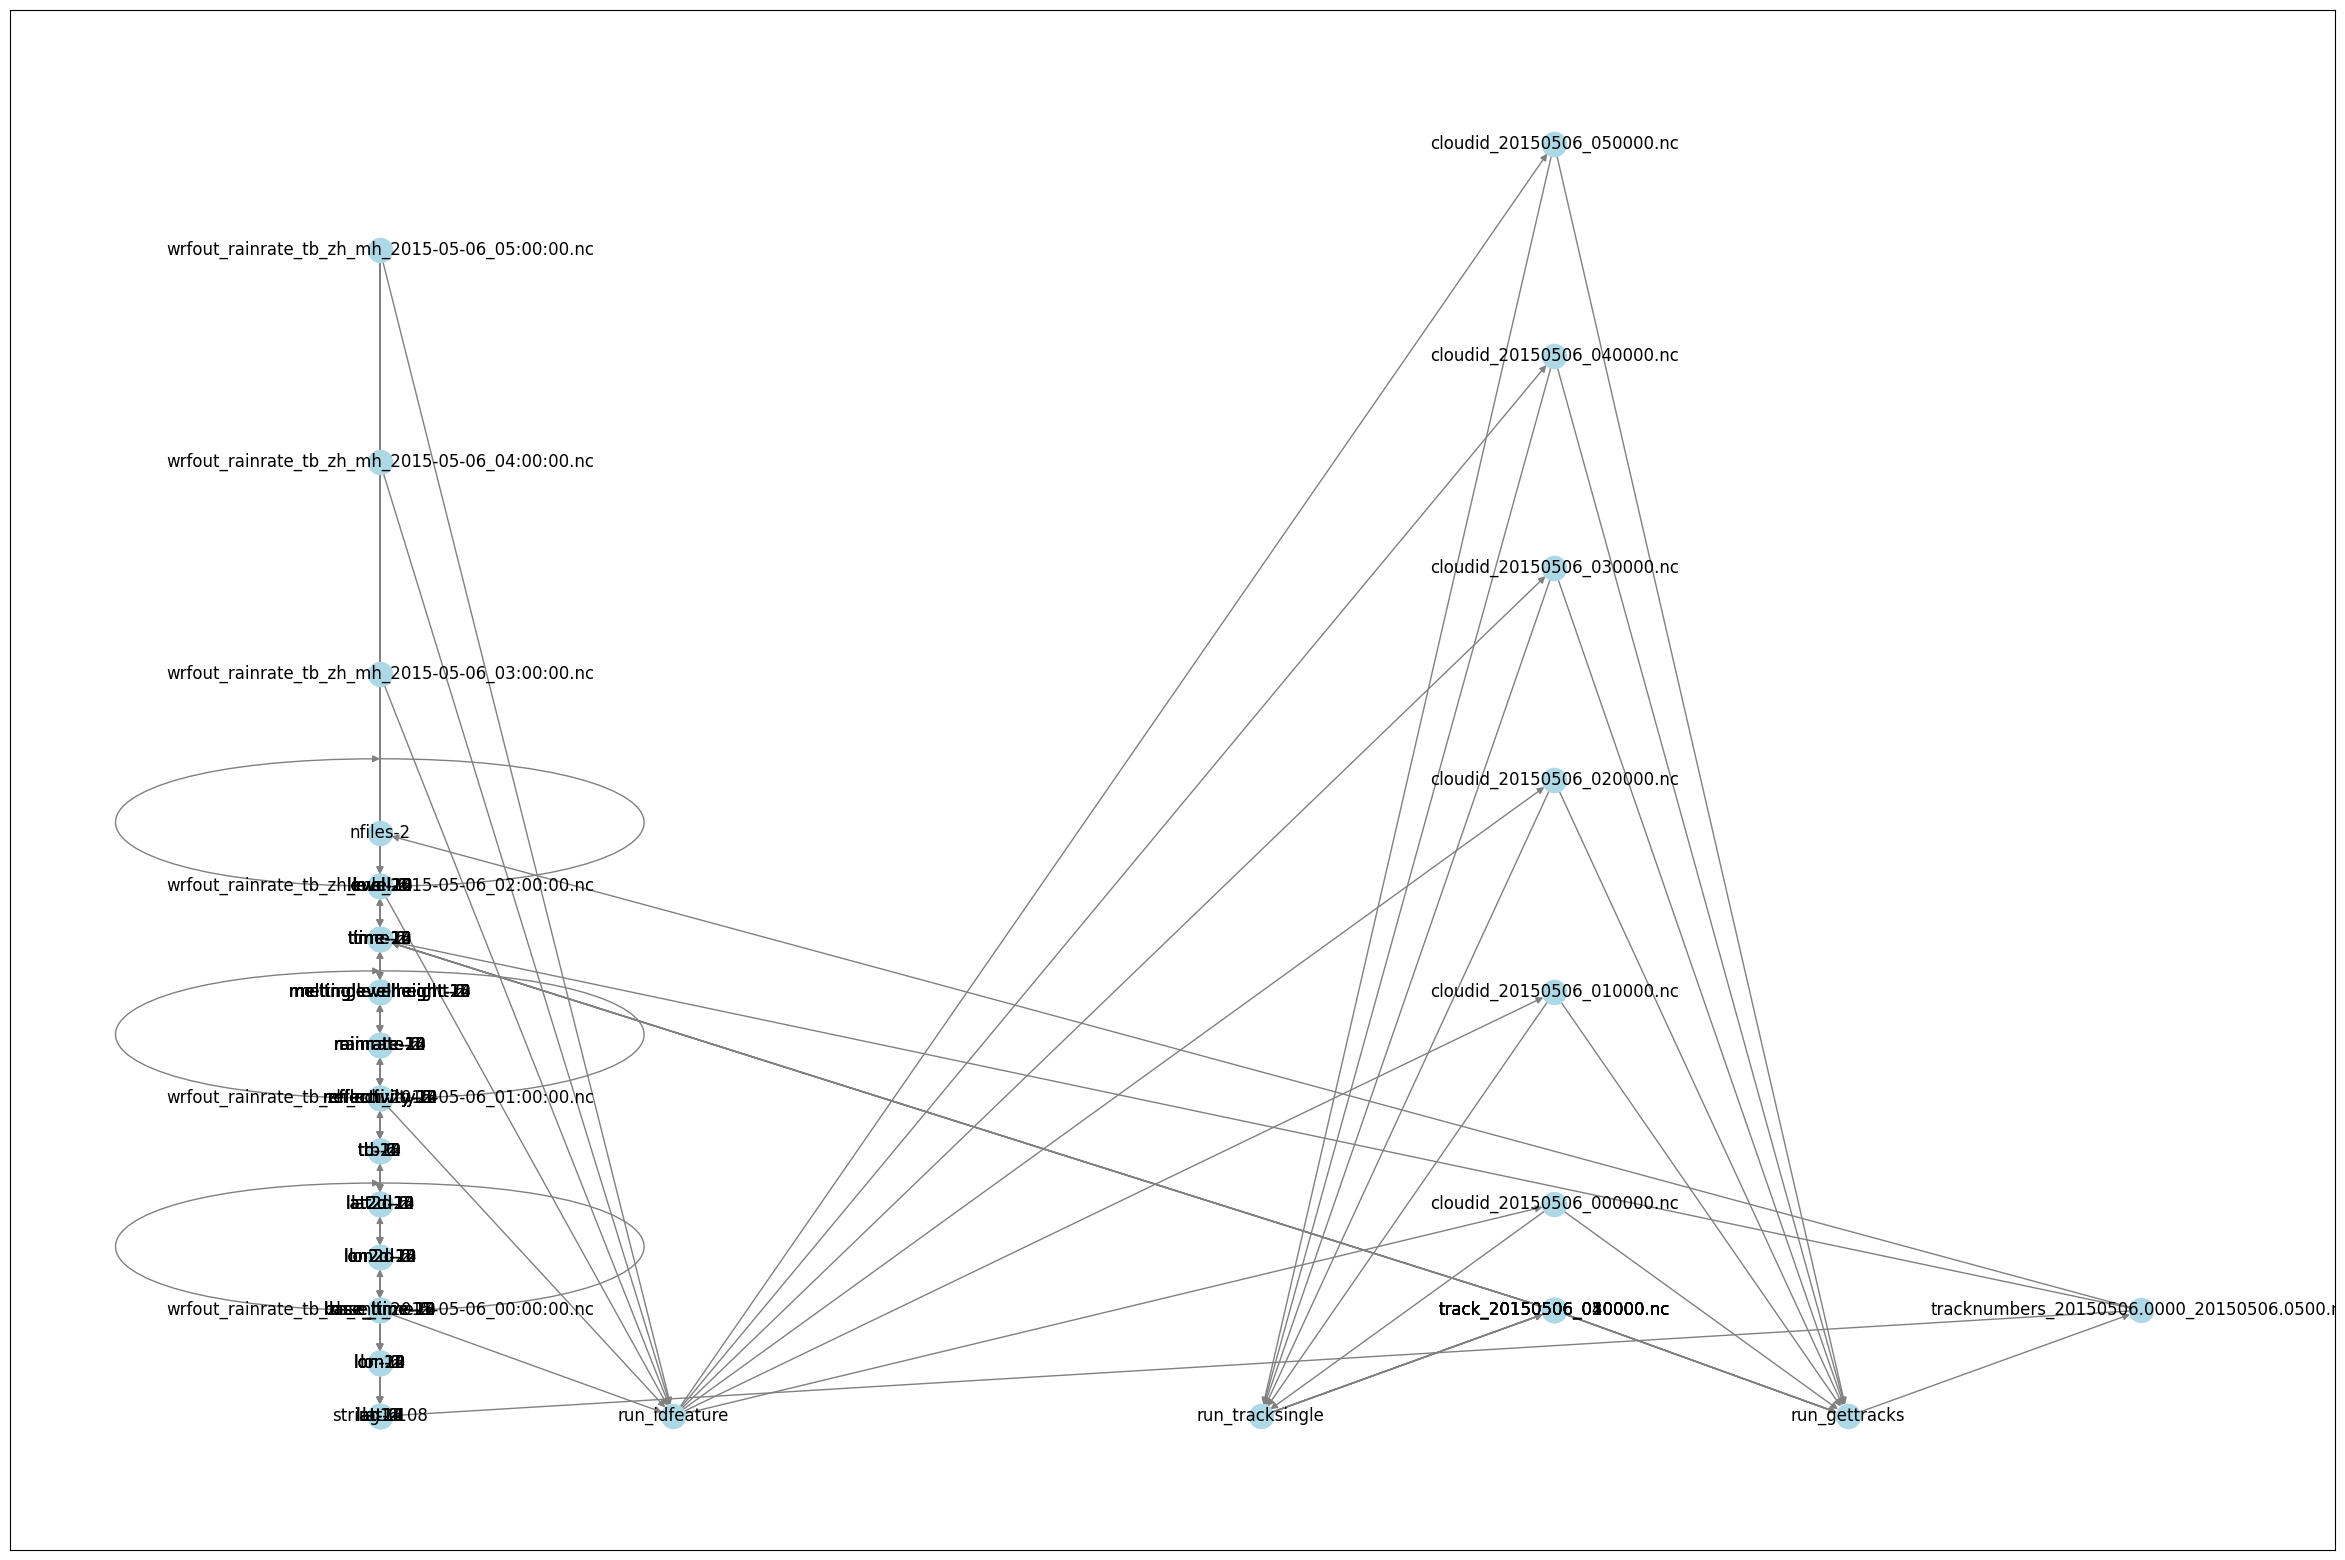

In [9]:

    
    
    
draw_graph(G_VOL, test_name)

In [10]:
# Add to network x

# for node in G_VOL.nodes():
#     print(f"node : {node}")
#     print(f"stat : {G_VOL.nodes[node]['stat']}")
#     # G_VOL.nodes[node]['stat']
#     print("")


# def add_dataset_nodes_edges(G):
#     skip_pos = 2
#     dataset_pos = 1
#     edge_occurence = 0
#     prev_edge = ""
#     # iterate through current edges
#     for u,v in G.edges():
#         curr_edge = f"({u},{v})"
#         if G.nodes[u]['type'] == 'file':
#             u_stat = G.nodes[u]['stat']
#             dataset_node = u_stat['datasets']

#             # offlead Graph stat to dataset node
#             G.nodes[u]['stat'] = {}

#             print(f"edge ({u},{v}) dataset_node: {dataset_node}")

#             dataset_node_name = f"{dataset_node['dset_name']}-({u},{v})"
#             G.add_node(dataset_node_name, pos=(0,dataset_pos))

#         elif G.nodes[v]['type'] == 'file':
#             v_stat = G.nodes[v]['stat']
#             dataset_node = v_stat['datasets']
#             print(f"edge ({u},{v}) dataset_node: {dataset_node}")
#         prev_edge = f"({u},{v})"
        

    # # task_file_edges dictionay
    # for dataset_name,v in tfe_dic.items():
    #     dataset_order = v['order']
    #     node_attrs = {dataset_name: {'order': dataset_order, 'type':'dataset', 'stat':v}}
    #     G.add_node(dataset_name, pos=(0,dataset_pos))
    #     nx.set_node_attributes(G, node_attrs)
    #     dataset_pos += skip_pos

add_dataset_nodes_edges(G_VOL)

NameError: name 'add_dataset_nodes_edges' is not defined